## Exposure function - workflow

'''Run tidal modelling'''
1. Generate complete list of datetimes to feed into tidal model (all_datetimes)
2. Calculate tide height for each datetime (given tidepost lat and lon, all_tideheights)
3. Save dates and modelled tideheights to dataframe (modelledtides)

''' Update timezone for location'''
1. Set the timezone from the tidepost lat/lon
2. Convert modelledtides index to local timezone

'''Filter data'''

For all_time data:
1. Save modelledtides in filters dictionary (filters, key = all_time)

'''Create wet/dry boolean for each timestep'''
1. Mask all modelled timesteps (from `filters`) by tideheight relative to NIDEM
2. Save xr array into new WetDry dictionary (WetDry)

'''Calculate the % exposure per pixel'''
1. Create empty xr.DataSet and append new DataArrays when looping through WetDry (pxpc2)
2. Calculate the mean of the boolean acroos the datetime axis (equiv. to % True) (pxpc)
3. Mask out non-intertidal areas (pxpc > 0)
4. Append pxpc to results dataset (pxpc2) (This step is important if more than 1 filter is applied. It's a little redundant when the nominated filter is `all_time')
5. pxpc2.compute

In [ ]:
!pip install sunriset
import sunriset ##(will need to `pip install sunriset` on first loading) ##for use in daily sunrise/set times. Could be moved into exp_ds func

In [1]:
%cd '/home/jovyan/dev/dea-notebooks/Claire/Intertidal_exposure/'
# %pwd

/home/jovyan/dev/dea-notebooks/Claire/Intertidal_exposure


In [7]:
import datacube
from datacube.utils import geometry

import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np

# import sunriset ##(will need to `pip install sunriset` on first loading) ##for use in daily sunrise/set times. Could be moved into exp_ds func
from otps import TimePoint
from otps import predict_tide
import pytz
import math
import datetime
from datetime import timedelta
from math import ceil
from scipy.signal import argrelmax ##used in calculation of spring/neap tides. Could be moved into exp_ds func
from scipy.signal import argrelmin ##used in calculation of spring/neap tides. Could be moved into exp_ds func
from scipy.interpolate import interp1d # for interpolation of new data points

import sys
sys.path.append("../../Scripts")
from dea_plotting import map_shapefile
from dea_dask import create_local_dask_cluster

import numpy as np
import matplotlib.pyplot as plt

# solar modelling modules
# import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'svg'

ModuleNotFoundError: No module named 'dea_plotting'

In [3]:
dc = datacube.Datacube(app="intertidal_exposure")
create_local_dask_cluster()

NameError: name 'create_local_dask_cluster' is not defined

In [ ]:
## Set variables 

# Read in the polygon vector file
%cd '/home/jovyan/dev/dea-notebooks/Claire/Intertidal_exposure/ITEM_voronois/'
# vector_file = "Queensland_coastline_east_ITEM_voronois.shp"
vector_file = "ID_GladstoneHarbour_QLDeast_latsplit_1000m_EPSG3577.shp"
attribute_col = "id_1"
gdf_master = gpd.read_file(vector_file)

## Drop unrequired duplicate columns
# droplabels = ['min_exp','max_exp', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70','70-80', '80-90', '90-100']
droplabels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70','70-80', '80-90', '90-100']
gdf_master.drop(labels=droplabels, axis=1, inplace=True)


## Add columns for tidal_offset plotting
gdf_master = gdf_master.reindex(columns = gdf_master.columns.tolist() + 
                                ['0-10','10-20','20-30',
                                 '30-40','40-50','50-60','60-70','70-80',
                                 '80-90','90-100', 'px_count'])

# # Add columns for tidal_offset plotting
# gdf_master = gdf_master.reindex(columns = gdf_master.columns.tolist() + 
#                                 ['springlow_0-10','springlow_10-20','springlow_20-30',
#                                  'springlow_30-40','springlow_40-50','springlow_50-60','springlow_60-70','springlow_70-80',
#                                  'springlow_80-90','springlow_90-100', 'springlow_px_count',
#                                  'springhigh_0-10','springhigh_10-20','springhigh_20-30',
#                                  'springhigh_30-40','springhigh_40-50','springhigh_50-60','springhigh_60-70','springhigh_70-80',
#                                  'springhigh_80-90','springhigh_90-100', 'springhigh_px_count',
#                                  'neaplow_0-10','neaplow_10-20','neaplow_20-30',
#                                  'neaplow_30-40','neaplow_40-50','neaplow_50-60','neaplow_60-70','neaplow_70-80',
#                                  'neaplow_80-90','neaplow_90-100', 'neaplow_px_count',
#                                  'neaphigh_0-10','neaphigh_10-20','neaphigh_20-30',
#                                  'neaphigh_30-40','neaphigh_40-50','neaphigh_50-60','neaphigh_60-70','neaphigh_70-80',
#                                  'neaphigh_80-90','neaphigh_90-100', 'neaphigh_px_count'])

# ## Index by date. This may break when time_start or time_end do not appear in the filtered dataset
## Ideally: 18.61 year window (19 years), the global average astronomically forced lunar nodal cycle (e.g. Haigh et al., 2011)
## NOTE: tidal and exposure modelling are set from the `time_start` and `time_end` parameters
time_start = '2001-01-01 00:00:00'
time_end = '2020-01-01 00:00:00'

## Set the frequency to run the tidal modelling
modelled_freq='30min'

# ## Set the filter to apply for the exposure modelling
# time_filter = 'Oct'

query = {
    'product': ['nidem'],
    "dask_chunks": {"time": 1, "x": 100000, "y": 100000}
        }

%cd '/home/jovyan/dev/dea-notebooks/Claire/Intertidal_exposure/'

In [10]:
gdf_master.columns

NameError: name 'gdf_master' is not defined

In [11]:
## Exposure modelling function
def exp_model(time_start, time_end, time_filter, modelled_freq, tidepost_lat, tidepost_lon):#, round_stats):
    
    '''
    For each modelled timestep in modelledtides,
    mask NIDEM for the associated tideheight.
    Save the lists of timesteps and masked arrays
    and concatenate to join all arrays on the new
    dimension 'datetime'
    
    Time filtering (`time_filter`) options for exposure mapping routine are:
    all_time,
    daynight,
    springneap,
    wet,
    dry,
    summer,
    autumn,
    winter,
    spring,
    Jan,
    Feb,
    Mar,
    Apr,
    May,
    Jun,
    Jul,
    Aug,
    Sep,
    Oct,
    Nov,
    Dec,
    'wet_springneap'
    
    Automated tidepost matching to associated `timezone`
    UTC       =  pytz.UTC ## Coordinated Universal Time
    UTC + 8   = 'Australia/West'

    UTC + 9.5 = 'Australia/North'
                'Australia/South'

    UTC + 10  = 'Australia/Queensland'
                'Australia/NSW'
                'Australia/Victoria'
                'Australia/Tasmania'
    '''
    '''------------------------------------'''
    ## Run tidal modelling

    # Generate range of times covering entire period of satellite record
    all_timerange = pd.date_range(start=time_start,
                                  end=time_end,
                                  freq=modelled_freq)
    all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

    # Use the tidal model to compute tide heights for each observation:  
    all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
                      for dt in all_datetimes]
    all_predictedtides = predict_tide(all_timepoints)   
    all_tideheights = [predictedtide.tide_m for predictedtide 
                        in all_predictedtides]
        ## Save modelled tides as dataframe
        ## Firstly convert the dates to series
    all_timerange = all_timerange.to_series()
        ## Save dates and tideheights to pd.DataFrame
    modelledtides = pd.DataFrame(data={'timerange': all_timerange,
                       'tideheights': all_tideheights})
    
    print ('Complete: Tidal modelling. Starting: Local timezone conversion')

    '''---------------------------------------------------------'''
    ## Automate timezone selection based on location of tidepost
    ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
    if tidepost_lon <= 129.0:
        timezone = 'Australia/West'
        local_tz = 8
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/North'
        local_tz = 9.5
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
        timezone = 'Australia/South'
        local_tz = 9.5
    elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/Queensland'
        local_tz = 10
    elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
        timezone = 'Australia/NSW'
        local_tz = 10
    else:
        print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
    print('Timezone set to', timezone)
    
    ## Convert time_start and time_end to datetime objects in local timezone
    time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
    time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)
    
    ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
    localtides = modelledtides.index.tz_localize(tz=pytz.UTC)

    ## Convert tz-aware index to local timezone
    localtides = localtides.tz_convert(timezone)
    
    ## Reset the index of modelledtides to reflect local times
    modelledtides['local_timerange'] = localtides
    modelledtides.set_index('local_timerange', inplace=True)
    modelledtides.drop('timerange', axis=1, inplace=True)
    
    print ('Complete: Local timezone conversion. Starting: filtering')
    
    '''---------------------------------'''
    ## Prepare data for use in solar modelling function (sunriset)
    ## Translate input dates to datetime
    format = '%Y-%m-%d %H:%M:%S'
    start = pd.to_datetime(time_start, format=format)
    end = pd.to_datetime(time_end, format=format)

    ## Calculate number of days between input dates
    diff = end-start

    ## Return difference in years
    yearsdiff = diff.days/365

    ## Round up to ensure all modelledtide datetimes are captured in solar model
    yearsdiff = int(math.ceil(yearsdiff))

    ## Identify variables for solar model input
    lat = tidepost_lat ## from tidepost
    long = tidepost_lon ## from tidepost
#     local_tz = local_tz  ## hardcoded for 3 Austral regions

    number_of_years = yearsdiff
    start_date = datetime.date(start.year, start.month, start.day) ## from query
    
    ## Create all required time filters
    ## Create dict to store filtered times
    filters = {}
    
    ## Create a filteredtides dataframe for the filters of interest
    for x in time_filter:
        
        if x == 'all_time':
            filteredtides = modelledtides
            filters[str(x)] = filteredtides

        elif x == 'daynight':

            ## Model sunrise and sunset
            sun_df = sunriset.to_pandas(start_date, lat, long, local_tz, number_of_years)

            ## Return sunrise/sunset in hh:mm:ss format (str)
            sun_df['Sunrise hh:mm:ss'] = sun_df['Sunrise'].apply(
                    lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))
            sun_df['Sunset hh:mm:ss'] = sun_df['Sunset'].apply(
                    lambda numpy_td: str(timedelta(seconds=numpy_td.total_seconds())))

            ## Drop accessory columns
            sun_df = sun_df[['Sunrise hh:mm:ss','Sunset hh:mm:ss']]

            ## Set the index as a datetimeindex to match the modelledtide df
            sun_df = sun_df.set_index(pd.DatetimeIndex(sun_df.index))
            
            ## Create dataframe from localtides (lt_df)
            lt_df=pd.DataFrame(localtides, columns=['localtides'])
            dates = []
            times = []
            for element in localtides:
                d = element.date()
                dates.append(d)
                t = element.time()
                times.append(t)
            lt_df['Date'] = dates
            lt_df['Time'] = times

            ## Generate empty dateframe to concatenate day and night attributed timesteps into
            ltdaynight_df = pd.DataFrame()

            for index,row in sun_df.iterrows():

                ## Translate the time string from sunriset module into datetime.time
                hourday = (int(row['Sunrise hh:mm:ss'].split(':')[0]))
                minuteday = (int(row['Sunrise hh:mm:ss'].split(':')[1]))
#                 secday = ceil(float(row['Sunrise hh:mm:ss'].split(':')[-1]))
                sunrise = datetime.time(hourday, minuteday)#, secday)

                hournight = (int(row['Sunset hh:mm:ss'].split(':')[0]))
                minutenight = (int(row['Sunset hh:mm:ss'].split(':')[1]))
#                 secnight = ceil(float(row['Sunset hh:mm:ss'].split(':')[-1]))
                sunset = datetime.time(hournight, minutenight)#, secnight)

                ## Assign day or night by comparison against sunrise and sunset for the day
                conditions = [(lt_df.loc[lt_df['Date'] == index.date()].Time > sunrise) & (lt_df.loc[lt_df['Date'] == index.date()].Time < sunset)]
                choices = ['day']
                lt_df.loc[(lt_df['Date'] == index.date()), ['daynight']] = np.select(conditions, choices, default='night')

                ## Extract day and night arrays to filter localtides against as per other filtering routines
                day_df = lt_df[lt_df.daynight == 'day']
                night_df = lt_df[lt_df.daynight == 'night']

                ## Return values to DatetimeIndex
                day = pd.DatetimeIndex(day_df.localtides)
                night = pd.DatetimeIndex(night_df.localtides)
                
                ## Filtering modelledtides by nominated timerange
                filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in day.array)
                filteredtides['timerange'] = day
                filteredtides.set_index('timerange', inplace=True)
                filteredtides.rename(columns={0:"tideheights"}, inplace=True)
                filters['day'] = filteredtides

                ## Filtering modelledtides by nominated timerange
                filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in night.array)
                filteredtides['timerange'] = night
                filteredtides.set_index('timerange', inplace=True)
                filteredtides.rename(columns={0:"tideheights"}, inplace=True)
                filters['night'] = filteredtides

        elif x == 'springneap':
            ## Find all spring and neap high tides

            ## All peaks(maxima) in modelledtides 
            Max = argrelmax(modelledtides[0:-1].tideheights.values)
            Max = np.array(Max[0])

            ## Find higher tides in the maxima then the spring high tides 
            maxhigh = argrelmax(modelledtides.tideheights[Max].values)
            maxhigh = np.array(maxhigh[0])
            springhigh = argrelmax(modelledtides.tideheights[Max[maxhigh]].values)
            springhigh = np.array(springhigh[0]) 

            ## Find lower tides in the maxima then the neap high tides
            maxlow = argrelmin(modelledtides.tideheights[Max].values)
            maxlow = np.array(maxlow[0])
            neaphigh = argrelmin(modelledtides.tideheights[Max[maxlow]].values)
            neaphigh = np.array(neaphigh[0])

            ## Repeat to determine spring and neap low tides.

            ## All minima in modelledtides 
            Min = argrelmin(modelledtides[0:-1].tideheights.values)
            Min = np.array(Min[0])

            ## Find higher tides in the maxima then the spring high tides 
            minhigh = argrelmin(modelledtides.tideheights[Min].values)
            minhigh = np.array(minhigh[0])
            springlow = argrelmin(modelledtides.tideheights[Min[minhigh]].values)
            springlow = np.array(springlow[0])

            ## Find lower tides in the maxima then the neap high tides
            minlow = argrelmax(modelledtides.tideheights[Min].values)
            minlow = np.array(minlow[0])
            neaplow = argrelmax(modelledtides.tideheights[Min[minlow]].values)
            neaplow = np.array(neaplow[0])

            # Add column to modelledtides to plot without using datetime values
            modelledtides['count'] = np.arange(0,len(modelledtides),1)

            ## Interpolate the high and low spring and neap curves
            neap_high_linear = interp1d(Max[maxlow], modelledtides.tideheights[Max[maxlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
            modelledtides['neap_high_interp'] = neap_high_linear(modelledtides['count'])

            spring_high_linear = interp1d(Max[maxhigh], modelledtides.tideheights[Max[maxhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
            modelledtides['spring_high_interp'] = spring_high_linear(modelledtides['count'])

            neap_low_linear = interp1d(Min[minlow], modelledtides.tideheights[Min[minlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
            modelledtides['neap_low_interp'] = neap_low_linear(modelledtides['count'])

            spring_low_linear = interp1d(Min[minhigh], modelledtides.tideheights[Min[minhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
            modelledtides['spring_low_interp'] = spring_low_linear(modelledtides['count'])

            ## Extract datetimeindex for each dataslice
            spring_high = modelledtides.tideheights[Max[maxhigh[springhigh]]].index
            spring_low = modelledtides.tideheights[Min[minhigh[springlow]]].index
            neap_high = modelledtides.tideheights[Max[maxlow[neaphigh]]].index
            neap_low = modelledtides.tideheights[Min[minlow[neaplow]]].index
            hightide = modelledtides[modelledtides.tideheights > modelledtides.neap_high_interp].index
            lowtide = modelledtides[modelledtides.tideheights < modelledtides.neap_low_interp].index

                            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in hightide.array)
            filteredtides['timerange'] = hightide
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters['hightide'] = filteredtides
            
                            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in lowtide.array)
            filteredtides['timerange'] = lowtide
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters['lowtide'] = filteredtides
            
                            ## Filtering model
            
            # ## Plot

            #     # Add column to modelledtides to plot without using datetime values
            # modelledtides['count'] = np.arange(0,len(modelledtides),1)
            #     # all modelled tides
            # plt.plot(modelledtides[0:-1]['count'], modelledtides[0:-1].tideheights) ## all modelled tide heights
            #     # spring and neap high tides
            # # plt.plot(Max, modelledtides.tideheights[Max], "X") ## all local maxima (orange)
            # # plt.plot(Max[maxhigh], modelledtides.tideheights[Max[maxhigh]], "X", color='red') ## higher tides in the maxima dataset (red)
            # plt.plot(Max[maxhigh[springhigh]], modelledtides.tideheights[Max[maxhigh[springhigh]]], "o", color='black') ##SPRING HIGH TIDES!! (black)
            # plt.plot(Max[maxlow[neaphigh]], modelledtides.tideheights[Max[maxlow[neaphigh]]], "o", color='red') ##NEAP HIGH TIDES!! (red)
            #     # spring and neap low tides
            # # plt.plot(Min, modelledtides.tideheights[Min], "X") ## all local maxima (orange)
            # # plt.plot(Min[minhigh], modelledtides.tideheights[Min[minhigh]], "X", color='red') ## higher tides in the maxima dataset (red)
            # plt.plot(Min[minhigh[springlow]], modelledtides.tideheights[Min[minhigh[springlow]]], "o", color='black') ##SPRING LOW TIDES!! (black)
            # plt.plot(Min[minlow[neaplow]], modelledtides.tideheights[Min[minlow[neaplow]]], "o", color='red') ##NEAP LOW TIDES!! (red)

        elif x == 'dry':
            dry = localtides.drop(localtides[(localtides.month == 10) ## Wet season: Oct-Mar
                        |(localtides.month == 11)
                        |(localtides.month == 12)
                        |(localtides.month == 1)
                        |(localtides.month == 2)
                        |(localtides.month == 3)
                        ])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in dry.array)
            filteredtides['timerange'] = dry
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'wet':
            wet = localtides.drop(localtides[(localtides.month == 4) ## Dry season: Apr-Sep
                        |(localtides.month == 5)
                        |(localtides.month == 6)
                        |(localtides.month == 7)
                        |(localtides.month == 8)
                        |(localtides.month == 9)
                        ])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in wet.array)
            filteredtides['timerange'] = wet
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'summer':
            summer = localtides.drop(localtides[localtides.quarter != 1])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in summer.array)
            filteredtides['timerange'] = summer
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'autumn':
            autumn = localtides.drop(localtides[localtides.quarter != 2])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in autumn.array)
            filteredtides['timerange'] = autumn
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'winter':
            autumn = localtides.drop(localtides[localtides.quarter != 3])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in winter.array)
            filteredtides['timerange'] = winter
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'spring':
            spring = localtides.drop(localtides[localtides.quarter != 4])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in spring.array)
            filteredtides['timerange'] = spring
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Jan':
            Jan = localtides.drop(localtides[localtides.month != 1])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jan.array)
            filteredtides['timerange'] = Jan
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Feb':
            Feb = localtides.drop(localtides[localtides.month != 2])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Feb.array)
            filteredtides['timerange'] = Feb
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Mar':
            Mar = localtides.drop(localtides[localtides.month != 3])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Mar.array)
            filteredtides['timerange'] = Mar
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Apr':
            Apr = localtides.drop(localtides[localtides.month != 4])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Apr.array)
            filteredtides['timerange'] = Apr
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'May':
            May = localtides.drop(localtides[localtides.month != 5])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in May.array)
            filteredtides['timerange'] = May
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Jun':
            Jun = localtides.drop(localtides[localtides.month != 6])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jun.array)
            filteredtides['timerange'] = Jun
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Jul':
            Jul = localtides.drop(localtides[localtides.month != 7])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Jul.array)
            filteredtides['timerange'] = Jul
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Aug':
            Aug = localtides.drop(localtides[localtides.month != 8])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Aug.array)
            filteredtides['timerange'] = Aug
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Sep':
            Sep = localtides.drop(localtides[localtides.month != 9])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Sep.array)
            filteredtides['timerange'] = Sep
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Oct':
            Oct = localtides.drop(localtides[localtides.month != 10])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Oct.array)
            filteredtides['timerange'] = Oct
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Nov':
            Nov = localtides.drop(localtides[localtides.month != 11])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Nov.array)
            filteredtides['timerange'] = Nov
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides

        elif x == 'Dec':
            Dec = localtides.drop(localtides[localtides.month != 12])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in Dec.array)
            filteredtides['timerange'] = Dec
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
            filters[str(x)] = filteredtides
        
        elif x == 'wet_springneap':
            wet = localtides.drop(localtides[(localtides.month == 4) ## Dry season: Apr-Sep
                        |(localtides.month == 5)
                        |(localtides.month == 6)
                        |(localtides.month == 7)
                        |(localtides.month == 8)
                        |(localtides.month == 9)
                        ])

            ## Filtering modelledtides by nominated timerange
            filteredtides = pd.DataFrame(modelledtides['tideheights'][timestep] for timestep in wet.array)
            filteredtides['timerange'] = wet
            filteredtides.set_index('timerange', inplace=True)
            filteredtides.rename(columns={0:"tideheights"}, inplace=True)
#             filters[str(x)] = filteredtides
            
#                     elif x == 'springneap':
            ## Find all spring and neap high tides

            ## All peaks(maxima) in modelledtides 
            Max = argrelmax(filteredtides[0:-1].tideheights.values)
            Max = np.array(Max[0])

            ## Find higher tides in the maxima then the spring high tides 
            maxhigh = argrelmax(filteredtides.tideheights[Max].values)
            maxhigh = np.array(maxhigh[0])
            springhigh = argrelmax(filteredtides.tideheights[Max[maxhigh]].values)
            springhigh = np.array(springhigh[0]) 

            ## Find lower tides in the maxima then the neap high tides
            maxlow = argrelmin(filteredtides.tideheights[Max].values)
            maxlow = np.array(maxlow[0])
            neaphigh = argrelmin(filteredtides.tideheights[Max[maxlow]].values)
            neaphigh = np.array(neaphigh[0])

            ## Repeat to determine spring and neap low tides.

            ## All minima in modelledtides 
            Min = argrelmin(filteredtides[0:-1].tideheights.values)
            Min = np.array(Min[0])

            ## Find higher tides in the maxima then the spring high tides 
            minhigh = argrelmin(filteredtides.tideheights[Min].values)
            minhigh = np.array(minhigh[0])
            springlow = argrelmin(filteredtides.tideheights[Min[minhigh]].values)
            springlow = np.array(springlow[0])

            ## Find lower tides in the maxima then the neap high tides
            minlow = argrelmax(filteredtides.tideheights[Min].values)
            minlow = np.array(minlow[0])
            neaplow = argrelmax(filteredtides.tideheights[Min[minlow]].values)
            neaplow = np.array(neaplow[0])

            # Add column to modelledtides to plot without using datetime values
            filteredtides['count'] = np.arange(0,len(filteredtides),1)

#             ## Interpolate the high and low spring and neap curves
#             neap_high_linear = interp1d(Max[maxlow], filteredtides.tideheights[Max[maxlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
#             filteredtides['neap_high_interp'] = neap_high_linear(filteredtides['count'])

# #             spring_high_linear = interp1d(Max[maxhigh], filteredtides.tideheights[Max[maxhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
# #             filteredtides['spring_high_interp'] = spring_high_linear(filteredtides['count'])

#             neap_low_linear = interp1d(Min[minlow], filteredtides.tideheights[Min[minlow]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
#             filteredtides['neap_low_interp'] = neap_low_linear(filteredtides['count'])

# #             spring_low_linear = interp1d(Min[minhigh], filteredtides.tideheights[Min[minhigh]].values, bounds_error=False, kind='linear', fill_value='extrapolate')
# #             filteredtides['spring_low_interp'] = spring_low_linear(filteredtides['count'])

            ## Extract datetimeindex for each dataslice
            spring_high = filteredtides.tideheights[Max[maxhigh[springhigh]]].index
            spring_low = filteredtides.tideheights[Min[minhigh[springlow]]].index
            neap_high = filteredtides.tideheights[Max[maxlow[neaphigh]]].index
            neap_low = filteredtides.tideheights[Min[minlow[neaplow]]].index
#             hightide = filteredtides[filteredtides.tideheights > filteredtides.neap_high_interp].index
#             lowtide = filteredtides[filteredtides.tideheights < filteredtides.neap_low_interp].index

#                             ## Filtering modelledtides by nominated timerange
#             filteredtides1 = pd.DataFrame(filteredtides['tideheights'][timestep] for timestep in hightide.array)
#             filteredtides1['timerange'] = hightide
#             filteredtides1.set_index('timerange', inplace=True)
#             filteredtides1.rename(columns={0:"tideheights"}, inplace=True)
#             filters['wet_hightide'] = filteredtides1
            
#                             ## Filtering modelledtides by nominated timerange
#             filteredtides1 = pd.DataFrame(filteredtides['tideheights'][timestep] for timestep in lowtide.array)
#             filteredtides1['timerange'] = lowtide
#             filteredtides1.set_index('timerange', inplace=True)
#             filteredtides1.rename(columns={0:"tideheights"}, inplace=True)
#             filters['wet_lowtide'] = filteredtides1
            
#                             ## Filtering modelledtides by nominated timerange
            filteredtides1 = pd.DataFrame(filteredtides['tideheights'][timestep] for timestep in spring_high.array)
            filteredtides1['timerange'] = spring_high
            filteredtides1.set_index('timerange', inplace=True)
            filteredtides1.rename(columns={0:"tideheights"}, inplace=True)
            filters['wet_spring_high'] = filteredtides1
            
                            ## Filtering modelledtides by nominated timerange
            filteredtides1 = pd.DataFrame(filteredtides['tideheights'][timestep] for timestep in spring_low.array)
            filteredtides1['timerange'] = spring_low
            filteredtides1.set_index('timerange', inplace=True)
            filteredtides1.rename(columns={0:"tideheights"}, inplace=True)
            filters['wet_spring_low'] = filteredtides1
            
                            ## Filtering modelledtides by nominated timerange
            filteredtides1 = pd.DataFrame(filteredtides['tideheights'][timestep] for timestep in neap_high.array)
            filteredtides1['timerange'] = neap_high
            filteredtides1.set_index('timerange', inplace=True)
            filteredtides1.rename(columns={0:"tideheights"}, inplace=True)
            filters['wet_neap_high'] = filteredtides1
            
                            ## Filtering modelledtides by nominated timerange
            filteredtides1 = pd.DataFrame(filteredtides['tideheights'][timestep] for timestep in neap_low.array)
            filteredtides1['timerange'] = neap_low
            filteredtides1.set_index('timerange', inplace=True)
            filteredtides1.rename(columns={0:"tideheights"}, inplace=True)
            filters['wet_neap_low'] = filteredtides1

        else:
            print('''
            Please select one of the following `time_filter`s: 
            all_time, day, night, springneap, wet, dry, summer, autumn, winter, 
            spring, Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec, 'wet_springneap'
            ''')
    
        print ('Complete: datetime filtering. Starting: wet/dry masking')
    
    ## Create wet/dry boolean for each timestep per filter
    WetDry = {}
    for key in filters:
                
        ## Boolean mask all modelled timesteps by tideheight relative to NIDEM:
        da_list = list(ds.nidem >= filters[str(key)]['tideheights'][timestep] 
                       for timestep in filters[str(key)].loc[time_start:time_end].index) 

        index_list = list(timestep for timestep in filters[str(key)][time_start:time_end].index)

        ## Store modelled datetimes as a pandas index
        index = pd.Index(index_list, name='datetime')

        ## Concatenate the arrays on the new dimension 'datetime'
        exp_ds = xr.concat(da_list, index)
        
        WetDry[str(key)] = exp_ds
        
    print ('Complete: wet/dry masking. Starting: exposure calculations')
    
    '''--------------------------------------------'''
    ## Calculate the pc exposure per pixel for each filter
    ## Build empty xr.ds and append each new da during looping through WetDry
    
    pxpc2 = ds#.squeeze().reset_coords() ## Copy of NIDEM ds to append exposure results into
    
    for f in WetDry:
    
            ## Calculate the mean of the boolean across the datetime axis (equiv. to % True)
        pxpc = WetDry[str(f)].mean('datetime')

#         # Compute the array from dask
#         pxpc = pxpc.compute() #%timeit

        ## Name the exposure time array
        pxpc = pxpc.rename('Exposure time (%)')

        ## Mask out non-intertidal areas
        pxpc = pxpc.where(pxpc > 0)
        
        ## Append filter (f) exposure results into results dataset (pxpc2)
        pxpc2[str(f)] = pxpc#.drop('time')

#         ## Save exposure results
#         pxpc.drop('time').to_netcdf("ID"
#                        + str(row.ID)
#                        + "_tidepost_"
#                        + str(tp_y) 
#                        + '_'
#                        + str(tp_x) 
#                        + "_pxpc_for_modelledtides20min_" 
#                        + str(time_start)
#                        + '_to_'
#                        + str(time_end)
#                        + "time_filter_"
#                        + str(time_filter)
#                        + ".nc")
#         # ## To save the NIDEM dataset to netcdf, need to remove the time dimension
#         ds = ds.squeeze()
#         ds = ds.reset_coords()
#         ds.nidem.to_netcdf("ID" + str(row.ID) +"_tidepost_"+str(tp_y) + '_'+ str(tp_x) +'nidem.nc') 

    print('Complete: exposure calculations. Starting: ds.compute')
    pxpc2 = pxpc2.compute()    
    print ('Complete: ds.compute')
#     return pxpc2#exp_ds
    return modelledtides, filters, pxpc2


In [12]:
## Bulk run cell: run exposure model and append observation values to master gdf

filters_all = {}
modelledtides_all = {}

## Prototyping the continental workflow
time_filter = ['wet']
## Prepare dict to store results
# ITEMpolygons = {}
# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf_master.iterrows():
    
    #     ## If a desired ITEM polygon is required, set the value here and 
#     ## enable the `break` at the end of this loop
#     if row.id_1 == 808: ##174-Moreton, 269-Gladstone, 198-Shoalwater
           
        
    # Extract the feature's geometry as a datacube geometry object
    geom = geometry.Geometry(geom=row.geometry, crs=gdf_master.crs)

    # Update the query to include our geopolygon
    query.update({"geopolygon": geom})

    ds = dc.load(**query)
    ds = ds.where(ds.nidem > ds.nidem.min())

    '''-------------------'''

    ## Run the exp_model function to generate tide model and exposure dataset
    modelledtides, filters, pxpc2 = exp_model(time_start, 
                       time_end,                        
                       time_filter,
                       modelled_freq,
                       tidepost_lat = row.lat, 
                       tidepost_lon = row.lon)


    # Save filtered, exposure results (pxpc2) per polyon in results dics
#     ITEMpolygons[str(row.ID)] = pxpc2

    ## Save a netcdf of the exposure results
    pxpc2.wet.drop('time').to_netcdf(
                                    'id'
                                   + str(row.id_1)
                                   + "_for_modelledtides30min_" 
                                   + str(time_start)
                                   + '_to_'
                                   + str(time_end)
                                   + "time_filter_wet_season"
#                                    + str(time_filter)
                                   + ".nc")
    
#     ## Save a netcdf of the exposure results
#     pxpc2.wet_spring_high.drop('time').to_netcdf(
#                                     'id'
#                                    + str(row.id_1)
#                                    + "_for_modelledtides30min_" 
#                                    + str(time_start)
#                                    + '_to_'
#                                    + str(time_end)
#                                    + "time_filter_wetspringhightide"
# #                                    + str(time_filter)
#                                    + ".nc")
#     ## Save a netcdf of the exposure results
#     pxpc2.wet_neap_low.drop('time').to_netcdf(
#                                     'id'
#                                    + str(row.id_1)
#                                    + "_for_modelledtides30min_" 
#                                    + str(time_start)
#                                    + '_to_'
#                                    + str(time_end)
#                                    + "time_filter_wetneaplow"
# #                                    + str(time_filter)
#                                    + ".nc")
    
#     ## Save a netcdf of the exposure results
#     pxpc2.wet_neap_high.drop('time').to_netcdf(
#                                     'id'
#                                    + str(row.id_1)
#                                    + "_for_modelledtides30min_" 
#                                    + str(time_start)
#                                    + '_to_'
#                                    + str(time_end)
#                                    + "time_filter_wetneaphigh"
# #                                    + str(time_filter)
#                                    + ".nc")

    filters_all[str(row.id_1)] = filters
    modelledtides_all[str(row.id_1)] = modelledtides

    '''---------------------------------'''
    ## Generate a summary fig of pixel counts per %exposure

    ## xarray series to dataframe
#     plotds = ITEMpolygons[str(row.ID)].all_time.to_dataframe()
#     plotds = netcdf_ds.all_time.to_dataframe()
    plotds = pxpc2.wet.to_dataframe()


    ## Bin the data in the exposure % column
#     ## values between which to bin the data
#     bins = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
    ## values between which to bin the data
    bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

#     ## labels for each bin
#     labels = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
    ## labels for each bin
    labels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

    ## assign the % exposure values to the appropriate bin
    plotds['binned'] = pd.cut(plotds['wet'],bins, labels=labels, ordered=True)

    ## new pandas.Series that counts all values per bin
    binned = plotds['binned'].value_counts()

    ## sort the index numerically
    binned.sort_index(inplace=True)

#     ## Append the observation values to gdf_master
#     gdf_master.loc[index, 'min_exp'] = pxpc2.all_time.min().values
#     gdf_master.loc[index, 'max_exp'] = pxpc2.all_time.max().values
    gdf_master.loc[index, '0-10'] = (binned[0])/binned.sum()
    gdf_master.loc[index, '10-20'] = (binned[0.1])/binned.sum()
    gdf_master.loc[index, '20-30'] = (binned[0.2])/binned.sum()
    gdf_master.loc[index, '30-40'] = (binned[0.3])/binned.sum()
    gdf_master.loc[index, '40-50'] = (binned[0.4])/binned.sum()
    gdf_master.loc[index, '50-60'] = (binned[0.5])/binned.sum()
    gdf_master.loc[index, '60-70'] = (binned[0.6])/binned.sum()
    gdf_master.loc[index, '70-80'] = (binned[0.7])/binned.sum()
    gdf_master.loc[index, '80-90'] = (binned[0.8])/binned.sum()
    gdf_master.loc[index, '90-100'] = (binned[0.9])/binned.sum()
    
# #     ## Append the observation values to gdf_master
# #     gdf_master.loc[index, 'min_exp'] = pxpc2.all_time.min().values
# #     gdf_master.loc[index, 'max_exp'] = pxpc2.all_time.max().values
#     gdf_master.loc[index, '0-10'] = (binned[0])#/binned.sum()
#     gdf_master.loc[index, '10-20'] = (binned[0.1])#/binned.sum()
#     gdf_master.loc[index, '20-30'] = (binned[0.2])#/binned.sum()
#     gdf_master.loc[index, '30-40'] = (binned[0.3])#/binned.sum()
#     gdf_master.loc[index, '40-50'] = (binned[0.4])#/binned.sum()
#     gdf_master.loc[index, '50-60'] = (binned[0.5])#/binned.sum()
#     gdf_master.loc[index, '60-70'] = (binned[0.6])#/binned.sum()
#     gdf_master.loc[index, '70-80'] = (binned[0.7])#/binned.sum()
#     gdf_master.loc[index, '80-90'] = (binned[0.8])#/binned.sum()
#     gdf_master.loc[index, '90-100'] = (binned[0.9])#/binned.sum()
#     gdf_master.loc[index, 'px_count'] = binned.sum()

#         ## Append the observation values to gdf_master

#     gdf_master.loc[index, 'springlow_0-10'] = (binned[0])#/binned.sum()
#     gdf_master.loc[index, 'springlow_10-20'] = (binned[0.1])#/binned.sum()
#     gdf_master.loc[index, 'springlow_20-30'] = (binned[0.2])#/binned.sum()
#     gdf_master.loc[index, 'springlow_30-40'] = (binned[0.3])#/binned.sum()
#     gdf_master.loc[index, 'springlow_40-50'] = (binned[0.4])#/binned.sum()
#     gdf_master.loc[index, 'springlow_50-60'] = (binned[0.5])#/binned.sum()
#     gdf_master.loc[index, 'springlow_60-70'] = (binned[0.6])#/binned.sum()
#     gdf_master.loc[index, 'springlow_70-80'] = (binned[0.7])#/binned.sum()
#     gdf_master.loc[index, 'springlow_80-90'] = (binned[0.8])#/binned.sum()
#     gdf_master.loc[index, 'springlow_90-100'] = (binned[0.9])#/binned.sum()
#     gdf_master.loc[index, 'springlow_px_count'] = binned.sum()

#     '''---------------------------------'''
#     ## Generate a summary fig of pixel counts per %exposure

#     ## xarray series to dataframe
# #     plotds = ITEMpolygons[str(row.ID)].all_time.to_dataframe()
# #     plotds = netcdf_ds.all_time.to_dataframe()
#     plotds = pxpc2.wet_spring_high.to_dataframe()


#     ## Bin the data in the exposure % column
# #     ## values between which to bin the data
# #     bins = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
#     ## values between which to bin the data
#     bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# #     ## labels for each bin
# #     labels = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
#     ## labels for each bin
#     labels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#     ## assign the % exposure values to the appropriate bin
# #     plotds['binned'] = pd.cut(plotds[time_filter[0]],bins, labels=labels, ordered=True)
#     plotds['binned'] = pd.cut(plotds['wet_spring_high'],bins, labels=labels, ordered=True)

#     ## new pandas.Series that counts all values per bin
#     binned = plotds['binned'].value_counts()

#     ## sort the index numerically
#     binned.sort_index(inplace=True)

#     gdf_master.loc[index, 'springhigh_0-10'] = (binned[0])#/binned.sum()
#     gdf_master.loc[index, 'springhigh_10-20'] = (binned[0.1])#/binned.sum()
#     gdf_master.loc[index, 'springhigh_20-30'] = (binned[0.2])#/binned.sum()
#     gdf_master.loc[index, 'springhigh_30-40'] = (binned[0.3])#/binned.sum()
#     gdf_master.loc[index, 'springhigh_40-50'] = (binned[0.4])#/binned.sum()
#     gdf_master.loc[index, 'springhigh_50-60'] = (binned[0.5])#/binned.sum()
#     gdf_master.loc[index, 'springhigh_60-70'] = (binned[0.6])#/binned.sum()
#     gdf_master.loc[index, 'springhigh_70-80'] = (binned[0.7])#/binned.sum()
#     gdf_master.loc[index, 'springhigh_80-90'] = (binned[0.8])#/binned.sum()
#     gdf_master.loc[index, 'springhigh_90-100'] = (binned[0.9])#/binned.sum()
#     gdf_master.loc[index, 'springhigh_px_count'] = binned.sum()
#     '''---------------------------------'''
#     ## Generate a summary fig of pixel counts per %exposure

#     ## xarray series to dataframe
# #     plotds = ITEMpolygons[str(row.ID)].all_time.to_dataframe()
# #     plotds = netcdf_ds.all_time.to_dataframe()
#     plotds = pxpc2.wet_neap_low.to_dataframe()


#     ## Bin the data in the exposure % column
# #     ## values between which to bin the data
# #     bins = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
#     ## values between which to bin the data
#     bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# #     ## labels for each bin
# #     labels = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
#     ## labels for each bin
#     labels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#     ## assign the % exposure values to the appropriate bin
#     plotds['binned'] = pd.cut(plotds['wet_neap_low'],bins, labels=labels, ordered=True)

#     ## new pandas.Series that counts all values per bin
#     binned = plotds['binned'].value_counts()

#     ## sort the index numerically
#     binned.sort_index(inplace=True)


#     gdf_master.loc[index, 'neaplow_0-10'] = (binned[0])#/binned.sum()
#     gdf_master.loc[index, 'neaplow_10-20'] = (binned[0.1])#/binned.sum()
#     gdf_master.loc[index, 'neaplow_20-30'] = (binned[0.2])#/binned.sum()
#     gdf_master.loc[index, 'neaplow_30-40'] = (binned[0.3])#/binned.sum()
#     gdf_master.loc[index, 'neaplow_40-50'] = (binned[0.4])#/binned.sum()
#     gdf_master.loc[index, 'neaplow_50-60'] = (binned[0.5])#/binned.sum()
#     gdf_master.loc[index, 'neaplow_60-70'] = (binned[0.6])#/binned.sum()
#     gdf_master.loc[index, 'neaplow_70-80'] = (binned[0.7])#/binned.sum()
#     gdf_master.loc[index, 'neaplow_80-90'] = (binned[0.8])#/binned.sum()
#     gdf_master.loc[index, 'neaplow_90-100'] = (binned[0.9])#/binned.sum()
#     gdf_master.loc[index, 'neaplow_px_count'] = binned.sum()

#     '''---------------------------------'''
#     ## Generate a summary fig of pixel counts per %exposure

#     ## xarray series to dataframe
# #     plotds = ITEMpolygons[str(row.ID)].all_time.to_dataframe()
# #     plotds = netcdf_ds.all_time.to_dataframe()
#     plotds = pxpc2.wet_neap_high.to_dataframe()


#     ## Bin the data in the exposure % column
# #     ## values between which to bin the data
# #     bins = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
#     ## values between which to bin the data
#     bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# #     ## labels for each bin
# #     labels = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
#     ## labels for each bin
#     labels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#     ## assign the % exposure values to the appropriate bin
# #     plotds['binned'] = pd.cut(plotds[time_filter[0]],bins, labels=labels, ordered=True)
#     plotds['binned'] = pd.cut(plotds['wet_neap_high'],bins, labels=labels, ordered=True)

#     ## new pandas.Series that counts all values per bin
#     binned = plotds['binned'].value_counts()

#     ## sort the index numerically
#     binned.sort_index(inplace=True)

#     gdf_master.loc[index, 'neaphigh_0-10'] = (binned[0])#/binned.sum()
#     gdf_master.loc[index, 'neaphigh_10-20'] = (binned[0.1])#/binned.sum()
#     gdf_master.loc[index, 'neaphigh_20-30'] = (binned[0.2])#/binned.sum()
#     gdf_master.loc[index, 'neaphigh_30-40'] = (binned[0.3])#/binned.sum()
#     gdf_master.loc[index, 'neaphigh_40-50'] = (binned[0.4])#/binned.sum()
#     gdf_master.loc[index, 'neaphigh_50-60'] = (binned[0.5])#/binned.sum()
#     gdf_master.loc[index, 'neaphigh_60-70'] = (binned[0.6])#/binned.sum()
#     gdf_master.loc[index, 'neaphigh_70-80'] = (binned[0.7])#/binned.sum()
#     gdf_master.loc[index, 'neaphigh_80-90'] = (binned[0.8])#/binned.sum()
#     gdf_master.loc[index, 'neaphigh_90-100'] = (binned[0.9])#/binned.sum()
#     gdf_master.loc[index, 'neaphigh_px_count'] = binned.sum()

#         break
        
    print('Completed polygon: ', row.id_1)

NameError: name 'gdf_master' is not defined

In [7]:
gdf_master.to_file("gdf_master_for_modelledtides30min_" 
                                   + str(time_start)
                                   + '_to_'
                                   + str(time_end)
                                   + time_filter[0]
                                   + "_filter"
                                   + ".shp")

## Save filters_all dict

import pickle

## Save filtered datetimes
filename = ("filtered_tides_for_modelledtides30min_" 
                                   + str(time_start)
                                   + '_to_'
                                   + str(time_end)
                                   + '_'
#                                    + time_filter[0]
                                   + 'wet_season'
                                   + "_filter"
                                   + ".pickle")
## Save dict as pickle
with open(filename, 'wb') as handle:
    pickle.dump(filters_all, handle)

## Save modelledtides datetimes
filename = ("modelled_tides_for_modelledtides30min_" 
                                   + str(time_start)
                                   + '_to_'
                                   + str(time_end)
                                   + '_'
#                                    + time_filter[0]
                                   + 'wet_season'
                                   + "_filter"
                                   + ".pickle")
## Save dict as pickle
with open(filename, 'wb') as handle:
    pickle.dump(modelledtides_all, handle)
    
# ## Open pickled dict
# with open(filename, 'rb') as handle:
#     filters_all = pickle.load(handle)

In [3]:
import pickle

## Open pickled dict
with open('filtered_tides_for_modelledtides30min_2001-01-01 00:00:00_to_2020-01-01 00:00:00_wet_season_filter.pickle', 'rb') as handle:
    filters_all = pickle.load(handle)

# ## Open pickled dict
# with open(filename, 'rb') as handle:
#     filters_all = pickle.load(handle)

# ## Open pickled dict
# with open(filename, 'rb') as handle:
#     filters_all = pickle.load(handle)

# ## Open pickled dict
# with open(filename, 'rb') as handle:
#     filters_all = pickle.load(handle)

NameError: name 'pickle' is not defined

In [9]:
# gdf_master.columns

In [10]:
## drop duplicate columns

## Manually rename columns to remove duplicate labels
# gdf_master.columns = ([
#                 'ID', 'lon', 'lat', 'LOT', 'HOT', 'LMT', 'HMT', 
#                 'id_1', 'min_exp1','max_exp1', '0-101', '10-201', '20-301', '30-401', '40-501', '50-601', '60-701','70-801', '80-901', '90-1001', 
#                 'geometry','min_exp', 'max_exp', '0-10','10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90','90-100', 'px_count'
#                 ])

## Drop unrequired duplicate columns
# droplabels = ['min_exp1','max_exp1', '0-101', '10-201', '20-301', '30-401', '40-501', '50-601', '60-701','70-801', '80-901', '90-1001']
# gdf_master.drop(labels=droplabels, axis=1, inplace=True)
# gdf_master.columns

In [8]:
# pwd
%cd '/home/jovyan/dev/dea-notebooks/Claire/'
import matplotlib.pyplot as plt

/home/jovyan/dev/dea-notebooks/Claire


In [9]:
### TEMP

vector_file = "gdf_master_for_modelledtides30min_2009-02-01 00_00_00_to_2009-03-01 00_00_00all_time_filter_tide_offset_and_exp_fraction.shp"
attribute_col = "id_1"
gdf_master = gpd.read_file(vector_file)

# gdf_master

In [16]:
gdf_master.columns

Index(['ID', 'lon', 'lat', 'LOT', 'HOT', 'LMT', 'HMT', 'id_1', 'min_exp',
       'max_exp', '0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70',
       '70-80', '80-90', '90-100', 'geometry'],
      dtype='object')

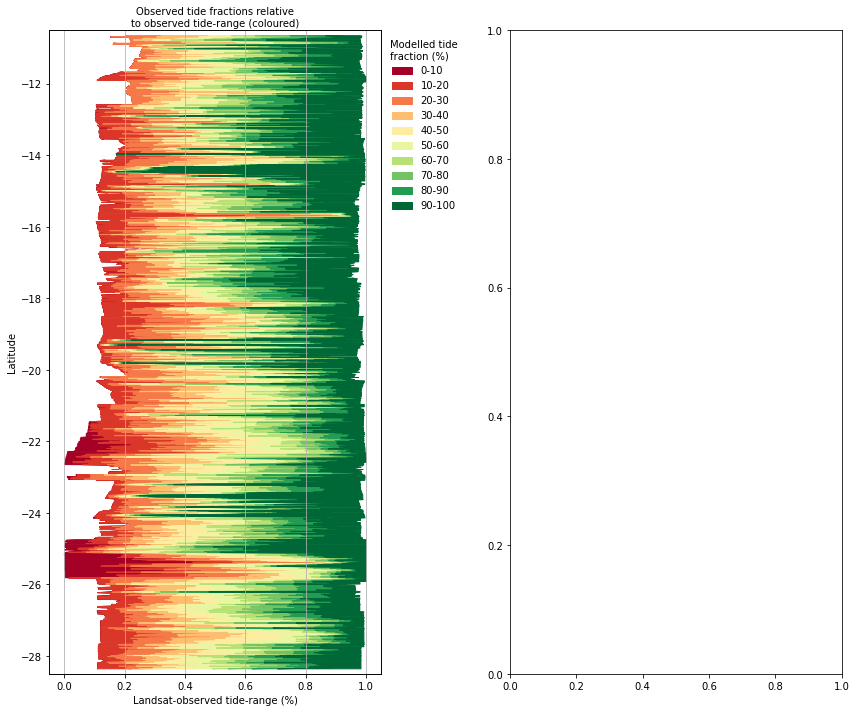

In [26]:
## Generate the summary plots for tidal offset and pixel % cover
## https://matplotlib.org/stable/gallery/lines_bars_and_markers/fill_between_demo.html

## Sort the dataframe in descending order based on latitude
gdf_master.sort_values('lat', ascending=False, inplace=True)

# ## Create the data labels for the legend
# category_names = gdf_master.columns.tolist()[-10:]

## Create the data labels for the legend
category_names = gdf_master.columns.tolist()[-11:-1]

## Overly complicated method to generate the colour ramp (borrowed code. TODO: simplify)
results = {}
for n in range (0,len(gdf_master)):
    results[gdf_master.loc[n].lat] = gdf_master.loc[n][-10:].values.tolist()

## Generate the colour ramp
data = np.array(list(results.values()))
category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.0, 1.0, data.shape[1]))

## Generate the cumulative pixel fractions (when pixel counts are fraction of total)
x=gdf_master['0-10']
x1=gdf_master['0-10']+gdf_master['10-20']
x2=gdf_master['0-10']+gdf_master['10-20']+gdf_master['20-30']
x3=gdf_master['0-10']+gdf_master['10-20']+gdf_master['20-30']+gdf_master['30-40']
x4=gdf_master['0-10']+gdf_master['10-20']+gdf_master['20-30']+gdf_master['30-40']+gdf_master['40-50']
x5=gdf_master['0-10']+gdf_master['10-20']+gdf_master['20-30']+gdf_master['30-40']+gdf_master['40-50']+gdf_master['50-60']
x6=gdf_master['0-10']+gdf_master['10-20']+gdf_master['20-30']+gdf_master['30-40']+gdf_master['40-50']+gdf_master['50-60']+gdf_master['60-70']
x7=gdf_master['0-10']+gdf_master['10-20']+gdf_master['20-30']+gdf_master['30-40']+gdf_master['40-50']+gdf_master['50-60']+gdf_master['60-70']+gdf_master['70-80']
x8=gdf_master['0-10']+gdf_master['10-20']+gdf_master['20-30']+gdf_master['30-40']+gdf_master['40-50']+gdf_master['50-60']+gdf_master['60-70']+gdf_master['70-80']+gdf_master['80-90']
x9=gdf_master['0-10']+gdf_master['10-20']+gdf_master['20-30']+gdf_master['30-40']+gdf_master['40-50']+gdf_master['50-60']+gdf_master['60-70']+gdf_master['70-80']+gdf_master['80-90']+gdf_master['90-100']

# ## Generate the cumulative pixel fractions (when pixel counts are sum per polygon)
# x=gdf_master['0-10']/gdf_master['px_count']

# x1=gdf_master['0-10']/gdf_master['px_count']+gdf_master['10-20']/gdf_master['px_count']
# x2=gdf_master['0-10']/gdf_master['px_count']+gdf_master['10-20']/gdf_master['px_count']+gdf_master['20-30']/gdf_master['px_count']
# x3=gdf_master['0-10']/gdf_master['px_count']+gdf_master['10-20']/gdf_master['px_count']+gdf_master['20-30']/gdf_master['px_count']+gdf_master['30-40']/gdf_master['px_count']
# x4=gdf_master['0-10']/gdf_master['px_count']+gdf_master['10-20']/gdf_master['px_count']+gdf_master['20-30']/gdf_master['px_count']+gdf_master['30-40']/gdf_master['px_count']+gdf_master['40-50']/gdf_master['px_count']
# x5=gdf_master['0-10']/gdf_master['px_count']+gdf_master['10-20']/gdf_master['px_count']+gdf_master['20-30']/gdf_master['px_count']+gdf_master['30-40']/gdf_master['px_count']+gdf_master['40-50']/gdf_master['px_count']+gdf_master['50-60']/gdf_master['px_count']
# x6=gdf_master['0-10']/gdf_master['px_count']+gdf_master['10-20']/gdf_master['px_count']+gdf_master['20-30']/gdf_master['px_count']+gdf_master['30-40']/gdf_master['px_count']+gdf_master['40-50']/gdf_master['px_count']+gdf_master['50-60']/gdf_master['px_count']+gdf_master['60-70']/gdf_master['px_count']
# x7=gdf_master['0-10']/gdf_master['px_count']+gdf_master['10-20']/gdf_master['px_count']+gdf_master['20-30']/gdf_master['px_count']+gdf_master['30-40']/gdf_master['px_count']+gdf_master['40-50']/gdf_master['px_count']+gdf_master['50-60']/gdf_master['px_count']+gdf_master['60-70']/gdf_master['px_count']+gdf_master['70-80']/gdf_master['px_count']
# x8=gdf_master['0-10']/gdf_master['px_count']+gdf_master['10-20']/gdf_master['px_count']+gdf_master['20-30']/gdf_master['px_count']+gdf_master['30-40']/gdf_master['px_count']+gdf_master['40-50']/gdf_master['px_count']+gdf_master['50-60']/gdf_master['px_count']+gdf_master['60-70']/gdf_master['px_count']+gdf_master['70-80']/gdf_master['px_count']+gdf_master['80-90']/gdf_master['px_count']
# x9=gdf_master['0-10']/gdf_master['px_count']+gdf_master['10-20']/gdf_master['px_count']+gdf_master['20-30']/gdf_master['px_count']+gdf_master['30-40']/gdf_master['px_count']+gdf_master['40-50']/gdf_master['px_count']+gdf_master['50-60']/gdf_master['px_count']+gdf_master['60-70']/gdf_master['px_count']+gdf_master['70-80']/gdf_master['px_count']+gdf_master['80-90']/gdf_master['px_count']+gdf_master['90-100']/gdf_master['px_count']



y=gdf_master.lat

## Plot
# fig, (ax2,ax1,ax) = plt.subplots(1,3, figsize=(8,10))


ax.fill_betweenx(y,0,x,color=category_colors[0], label=category_names[0])
ax.fill_betweenx(y,x,x1,color=category_colors[1],label=category_names[1])
ax.fill_betweenx(y,x1,x2,color=category_colors[2],label=category_names[2])
ax.fill_betweenx(y,x2,x3,color=category_colors[3],label=category_names[3])
ax.fill_betweenx(y,x3,x4,color=category_colors[4],label=category_names[4])
ax.fill_betweenx(y,x4,x5,color=category_colors[5],label=category_names[5])
ax.fill_betweenx(y,x5,x6,color=category_colors[6],label=category_names[6])
ax.fill_betweenx(y,x6,x7,color=category_colors[7],label=category_names[7])
ax.fill_betweenx(y,x7,x8,color=category_colors[8],label=category_names[8])
ax.fill_betweenx(y,x8,x9,color=category_colors[9],label=category_names[9])

ax1.fill_betweenx(y,gdf_master.min_exp,gdf_master.max_exp)
#----------------------------------------
## New plot
diff = gdf_master.max_exp - gdf_master.min_exp

fig, (ax2, ax3) = plt.subplots(1,2, figsize=(12,10))

ax2.fill_betweenx(y,gdf_master.min_exp ,(gdf_master.min_exp + x*diff),color=category_colors[0], label=category_names[0])
ax2.fill_betweenx(y,(gdf_master.min_exp + x*diff),(gdf_master.min_exp + x1*diff),color=category_colors[1],label=category_names[1])
ax2.fill_betweenx(y,(gdf_master.min_exp + x1*diff),(gdf_master.min_exp + x2*diff),color=category_colors[2],label=category_names[2])
ax2.fill_betweenx(y,(gdf_master.min_exp + x2*diff),(gdf_master.min_exp + x3*diff),color=category_colors[3],label=category_names[3])
ax2.fill_betweenx(y,(gdf_master.min_exp + x3*diff),(gdf_master.min_exp + x4*diff),color=category_colors[4],label=category_names[4])
ax2.fill_betweenx(y,(gdf_master.min_exp + x4*diff),(gdf_master.min_exp + x5*diff),color=category_colors[5],label=category_names[5])
ax2.fill_betweenx(y,(gdf_master.min_exp + x5*diff),(gdf_master.min_exp + x6*diff),color=category_colors[6],label=category_names[6])
ax2.fill_betweenx(y,(gdf_master.min_exp + x6*diff),(gdf_master.min_exp + x7*diff),color=category_colors[7],label=category_names[7])
ax2.fill_betweenx(y,(gdf_master.min_exp + x7*diff),(gdf_master.min_exp + x8*diff),color=category_colors[8],label=category_names[8])
ax2.fill_betweenx(y,(gdf_master.min_exp + x8*diff),(gdf_master.min_exp + x9*diff),color=category_colors[9], label=category_names[9])



# ax2.fill_betweenx(y, gdf_master.min_exp, gdf_master.max_exp)

ax3 = ax2.twiny()
ax3.plot()#label='label')
ax3.set_xticklabels(labels=[])
ax3.set_xticks([])
ax3.set_xlabel('Observed tide fractions relative\nto observed tide-range (coloured)')


ax2.grid(True, axis='x')
ax2.set_xlabel('Landsat-observed tide-range (%)')
ax2.set_ylabel('Latitude')
ax2.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Modelled tide\nfraction (%)',frameon=False)
ax2.set_ylim(-28.5, -10.5)
#------------------------------------------------
## Add the legend
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', title='Modelled tide\nfraction (%)',frameon=False)

ax1.grid(True, axis='x')

ax1.set_xlabel('a) Landsat-observed extent of\nfull modelled tide range (%)')
ax.set_xlabel('b) Landsat-observed modelled\ntide fractions (%)')
ax1.set_ylabel ('Latitude')
ax.set_yticklabels(labels=[])

ax1.set_xlim(-0.05,1.05)
# ax1.set_ylim(-28,-10.5)
# ax.set_ylim(-28,-10.5)

plt.tight_layout(w_pad=2.5)
plt.savefig('QLD_exposure_summary')
plt.show()


In [25]:
# ## Area per pixel (m2): 25 x 25 = 625 m^2
# # 625*16762
# # 0.025*0.025
# 0.0006250000000000001*2108

# # gdf_master

gdf_master.min_exp

1353    0.205948
1345    0.203717
1348    0.204461
1347         NaN
1346    0.153160
          ...   
2070    0.110781
2069    0.110781
2068    0.110781
2013    0.110781
2014    0.110781
Name: min_exp, Length: 2456, dtype: float64

In [27]:
x=gdf_master['0-10']
y=gdf_master.min_exp + x*(gdf_master.max_exp-gdf_master.min_exp)

In [ ]:
gdf_master.

In [116]:
# ## Workaround - I saved the wrong values for the binned pixel values into gdf_master. 
# ## This workaround reads in the netcdfs and calculates the correct values into gdf_master.

# import glob

# path = 'dev/dea-notebooks/Claire/Intertidal_exposure/'

# gpd_list = []
# for file in glob.glob('*.nc', recursive=False):
#     gpd_list.append(file)


# for index, row in gdf_master.iterrows():

#     for file in gpd_list:
        
#         if row.id_1 == int(file.split('_')[0].split('d')[1]):
        
#             pxpc2 = xr.open_dataset(file)

#             '''---------------------------------'''
#             ## Generate a summary fig of pixel counts per %exposure

#             ## xarray series to dataframe
#             plotds = pxpc2.wet.to_dataframe()


#             ## Bin the data in the exposure % column
#             ## values between which to bin the data
#             bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

#         #     ## labels for each bin
#             labels = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#             ## assign the % exposure values to the appropriate bin
#             plotds['binned'] = pd.cut(plotds['wet'],bins, labels=labels, ordered=True)

#             ## new pandas.Series that counts all values per bin
#             binned = plotds['binned'].value_counts()

#             ## sort the index numerically
#             binned.sort_index(inplace=True)

#         #     ## Append the observation values to gdf_master
#             gdf_master.loc[index, '0-10'] = (binned[0])#/binned.sum()
#             gdf_master.loc[index, '10-20'] = (binned[0.1])#/binned.sum()
#             gdf_master.loc[index, '20-30'] = (binned[0.2])#/binned.sum()
#             gdf_master.loc[index, '30-40'] = (binned[0.3])#/binned.sum()
#             gdf_master.loc[index, '40-50'] = (binned[0.4])#/binned.sum()
#             gdf_master.loc[index, '50-60'] = (binned[0.5])#/binned.sum()
#             gdf_master.loc[index, '60-70'] = (binned[0.6])#/binned.sum()
#             gdf_master.loc[index, '70-80'] = (binned[0.7])#/binned.sum()
#             gdf_master.loc[index, '80-90'] = (binned[0.8])#/binned.sum()
#             gdf_master.loc[index, '90-100'] = (binned[0.9])#/binned.sum()
#             gdf_master.loc[index, 'px_count'] = binned.sum()


In [120]:
# gdf_master

/tmp/ipykernel_1782/1357205592.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test = gdf_master.sum()


Text(0, 0.5, 'Landsat-observed area (km2)')

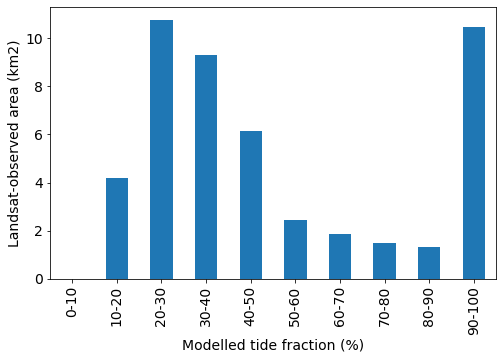

In [122]:
test = gdf_master.sum()
test2 = test[9:-1].mul((0.025*0.025))
test2[:].plot(kind='bar', figsize=(8,5), fontsize=14)
plt.xlabel('Modelled tide fraction (%)', fontsize=14)
plt.ylabel('Landsat-observed area (km2)', fontsize=14)

In [4]:
## Trying to re-load the gdf_master.shp file

# # Read in the polygon vector file
# %cd '/home/jovyan/dev/dea-notebooks/Claire/Intertidal_exposure/ITEM_voronois/'
# # vector_file = "Queensland_coastline_east_ITEM_voronois.shp"
vector_file = "gdf_master_for_modelledtides30min_2001-01-01 00:00:00_to_2020-01-01 00:00:00wet_filter.shp"
# attribute_col = "id_1"
gdf_master = gpd.read_file(vector_file)

/tmp/ipykernel_228/1791591866.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test = gdf_master.sum()


Text(0, 0.5, 'Landsat-observed area (km2)')

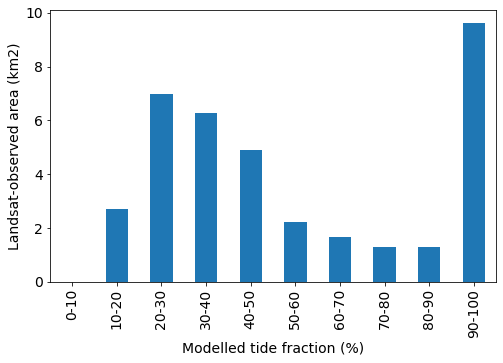

In [18]:
## Trying to colour code the bars in the above bar-graph

## Borrowed colour-bar code from above

# ## Sort the dataframe in descending order based on latitude
# gdf_master.sort_values('lat', ascending=False, inplace=True)

# # ## Create the data labels for the legend
# # category_names = gdf_master.columns.tolist()[-10:]

# ## Create the data labels for the legend
# category_names = gdf_master.columns.tolist()[-11:-1]

# ## Overly complicated method to generate the colour ramp (borrowed code. TODO: simplify)
# results = {}
# for n in range (0,len(gdf_master)):
#     results[gdf_master.loc[n].lat] = gdf_master.loc[n][-10:].values.tolist()

# ## Generate the colour ramp
# data = np.array(list(results.values()))
# category_colors = plt.get_cmap('RdYlGn')(np.linspace(0.0, 1.0, data.shape[1]))

## Plot

test = gdf_master.sum()
test2 = test[8:-1]#.mul((0.025*0.025))
test2[:].plot(kind='bar', figsize=(8,5), fontsize=14)
plt.xlabel('Modelled tide fraction (%)', fontsize=14)
plt.ylabel('Landsat-observed area (km2)', fontsize=14)

In [14]:
# test2[0:10].plot(kind='bar', figsize=(8,5), fontsize=14)
# plt.xlabel('Modelled tide fraction (%)', fontsize=14)
# plt.ylabel('Landsat-observed area (km2)', fontsize=14)
gdf_master
# test

,ID,lon,lat,LOT,HOT,LMT,HMT,id_1,0-10,10-20,20-30,30-40,40-50,50-60,60-70,70-80,80-90,90-100,px_count,geometry
0,110,151.46,-23.68,-0.745,1.533,-1.508,1.597,735,0.0,0.038095,0.105628,0.121212,0.119481,0.069264,0.028571,0.041558,0.030303,0.445887,None,"POLYGON ((1956480.044 -2706395.097, 1956805.88..."
1,110,151.47,-23.70,-0.745,1.533,-1.508,1.597,736,0.0,0.056084,0.177281,0.195342,0.135456,0.034221,0.026616,0.019962,0.027567,0.327471,None,"POLYGON ((1957131.729 -2708395.097, 1957457.57..."
2,110,151.47,-23.69,-0.745,1.533,-1.508,1.597,737,0.0,0.128959,0.312217,0.218100,0.097738,0.023077,0.012670,0.018100,0.014932,0.174208,None,"POLYGON ((1956805.887 -2707395.097, 1957131.72..."
3,110,151.48,-23.71,-0.745,1.533,-1.508,1.597,738,0.0,0.092738,0.193488,0.187521,0.158200,0.053358,0.044664,0.036993,0.018923,0.214115,None,"POLYGON ((1957783.415 -2710395.097, 1958109.25..."
4,110,151.48,-23.70,-0.745,1.533,-1.508,1.597,739,0.0,0.029982,0.110236,0.093580,0.075712,0.043004,0.049364,0.061478,0.046033,0.490612,None,"POLYGON ((1957457.572 -2709395.097, 1957783.41..."
5,110,151.49,-23.73,-0.745,1.533,-1.508,1.597,740,0.0,0.102374,0.315882,0.246594,0.129039,0.035812,0.020436,0.024912,0.015765,0.109186,None,"POLYGON ((1958435.100 -2712395.097, 1958760.94..."
6,110,151.49,-23.72,-0.745,1.533,-1.508,1.597,741,0.0,0.135236,0.289685,0.203320,0.110800,0.034695,0.021078,0.022197,0.015296,0.167693,None,"POLYGON ((1958109.257 -2711395.097, 1958435.10..."
7,110,151.43,-23.62,-0.745,1.533,-1.508,1.597,742,0.0,0.178922,0.294118,0.209314,0.097549,0.039216,0.031373,0.019608,0.016667,0.113235,None,"POLYGON ((1953873.302 -2698395.097, 1954199.14..."
8,110,151.44,-23.63,-0.745,1.533,-1.508,1.597,743,0.0,0.060023,0.209513,0.189128,0.097395,0.073613,0.033975,0.039638,0.031710,0.265006,None,"POLYGON ((1954524.988 -2700395.097, 1954850.83..."
9,110,151.43,-23.62,-0.745,1.533,-1.508,1.597,744,0.0,0.068783,0.155556,0.198942,0.159788,0.086772,0.075132,0.059259,0.028571,0.167196,None,"POLYGON ((1954199.145 -2699395.097, 1954524.98..."


In [ ]:
# filters_all['735']['wet_lowtide'][:1000].plot(style='.', fontsize=14, figsize=(8,5))
# # modelled_tides['735'].plot(style='.')
# plt.xlabel('Timerange', fontsize=14)
# plt.ylabel('Tideheight', fontsize=14)
# plt.legend(loc='upper left')
# # filters_all['735']['wet_hightide'].plot.scatter(x=(), y='tideheights')#, kind='scatter')#.scatter()

# # fig=plt.figure()
# # filters_all['735']['wet_hightide'].index.values

In [ ]:
# modelledtides_all

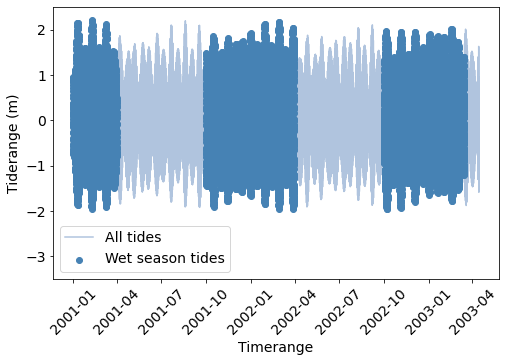

In [31]:
plt.rc('font', size=14)

fig, ax = plt.subplots(figsize=(8,5))#, fontsize=14)

ax.plot(modelledtides_all['735'][:40000].index.values, modelledtides_all['735'][:40000].tideheights, color='lightsteelblue', label='All tides', zorder=0)
ax.scatter(filters_all['735']['wet'][:21000].index.values, filters_all['735']['wet'][:21000].tideheights, color='steelblue', label='Wet season tides', zorder=1)
# ax.scatter(filters_all['735']['wet_hightide'].index.values, filters_all['735']['wet_hightide'].tideheights, color='steelblue', label='Wet season high tides')
ax.set_xlabel('Timerange')#, fontsize=14)
ax.set_ylabel('Tiderange (m)')#, fontsize=14)
ax.legend()
ax.set_ylim(-3.5,2.5)
ax.tick_params(axis='x', rotation=45)

plt.show()

In [ ]:
# plt.rc('font', size=14)

# fig, ax = plt.subplots(figsize=(8,5))#, fontsize=14)

# ax.scatter(modelled_tides['735'][:2200].index.values, modelled_tides['735'][:2200].tideheights, color='lightsteelblue', label='All tides')
# ax.scatter(filters_all['735']['wet_hightide'][:360].index.values, filters_all['735']['wet_hightide'][:360].tideheights, color='steelblue', label='Wet season low tides')
# # ax.scatter(filters_all['735']['wet_hightide'].index.values, filters_all['735']['wet_hightide'].tideheights, color='steelblue', label='Wet season high tides')
# ax.set_xlabel('Timerange')#, fontsize=14)
# ax.set_ylabel('Tiderange (m)')#, fontsize=14)
# ax.legend()
# ax.set_ylim(-3.5,2.5)
# ax.tick_params(axis='x', rotation=45)

# plt.show()

In [ ]:
modelled_tides

In [ ]:
## Exposure modelling function
def tidal_modelling(time_start, time_end, time_filter, modelled_freq, tidepost_lat, tidepost_lon):#, round_stats):
    
    '''
    For each modelled timestep in modelledtides,
    mask NIDEM for the associated tideheight.
    Save the lists of timesteps and masked arrays
    and concatenate to join all arrays on the new
    dimension 'datetime'
    
    Time filtering (`time_filter`) options for exposure mapping routine are:
    all_time,
    daynight,
    springneap,
    wet,
    dry,
    summer,
    autumn,
    winter,
    spring,
    Jan,
    Feb,
    Mar,
    Apr,
    May,
    Jun,
    Jul,
    Aug,
    Sep,
    Oct,
    Nov,
    Dec,
    'wet_springneap'
    
    Automated tidepost matching to associated `timezone`
    UTC       =  pytz.UTC ## Coordinated Universal Time
    UTC + 8   = 'Australia/West'

    UTC + 9.5 = 'Australia/North'
                'Australia/South'

    UTC + 10  = 'Australia/Queensland'
                'Australia/NSW'
                'Australia/Victoria'
                'Australia/Tasmania'
    '''
    '''------------------------------------'''
    ## Run tidal modelling

    # Generate range of times covering entire period of satellite record
    all_timerange = pd.date_range(start=time_start,
                                  end=time_end,
                                  freq=modelled_freq)
    all_datetimes = all_timerange.values.astype('M8[s]').astype('O').tolist()  

    # Use the tidal model to compute tide heights for each observation:  
    all_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) 
                      for dt in all_datetimes]
    all_predictedtides = predict_tide(all_timepoints)   
    all_tideheights = [predictedtide.tide_m for predictedtide 
                        in all_predictedtides]
        ## Save modelled tides as dataframe
        ## Firstly convert the dates to series
    all_timerange = all_timerange.to_series()
        ## Save dates and tideheights to pd.DataFrame
    modelledtides = pd.DataFrame(data={'timerange': all_timerange,
                       'tideheights': all_tideheights})
    
    print ('Complete: Tidal modelling. Starting: Local timezone conversion')

    '''---------------------------------------------------------'''
    ## Automate timezone selection based on location of tidepost
    ## State boundary coords from https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/border-lengths
    if tidepost_lon <= 129.0:
        timezone = 'Australia/West'
        local_tz = 8
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/North'
        local_tz = 9.5
    elif (tidepost_lon > 129.0) & (tidepost_lon <= 141.0) & (tidepost_lat > 26.0):
        timezone = 'Australia/South'
        local_tz = 9.5
    elif (tidepost_lon > 138.0) & (tidepost_lat < 26.0):
        timezone = 'Australia/Queensland'
        local_tz = 10
    elif (tidepost_lon > 141.0) & (tidepost_lat >= 26.0):
        timezone = 'Australia/NSW'
        local_tz = 10
    else:
        print('Unable to assign timezone from supplied tidepost coords (tidepost_lon and tidepost_lat)')
    print('Timezone set to', timezone)
    
    ## Convert time_start and time_end to datetime objects in local timezone
    time_start = pd.to_datetime(time_start, utc=True).tz_convert(timezone)
    time_end = pd.to_datetime(time_end, utc=True).tz_convert(timezone)
    
    ## Convert tz-naive to tz-aware (set to UTC to match modelled timestamp input)
    localtides = modelledtides.index.tz_localize(tz=pytz.UTC)

    ## Convert tz-aware index to local timezone
    localtides = localtides.tz_convert(timezone)
    
    ## Reset the index of modelledtides to reflect local times
    modelledtides['local_timerange'] = localtides
    modelledtides.set_index('local_timerange', inplace=True)
    modelledtides.drop('timerange', axis=1, inplace=True)
    
    return modelledtides

In [ ]:
## Bulk run cell: run exposure model and append observation values to master gdf

modelled_tides = {}

## Prototyping the continental workflow
time_filter = ['wet_springneap']

# Loop through polygons in geodataframe and extract satellite data
for index, row in gdf_master.iterrows():      
        
    # Extract the feature's geometry as a datacube geometry object
    geom = geometry.Geometry(geom=row.geometry, crs=gdf_master.crs)

    # Update the query to include our geopolygon
    query.update({"geopolygon": geom})

    ds = dc.load(**query)
    ds = ds.where(ds.nidem > ds.nidem.min())

    '''-------------------'''

    ## Run the exp_model function to generate tide model and exposure dataset
    modelledtides = tidal_modelling(time_start, 
                       time_end,                        
                       time_filter,
                       modelled_freq,
                       tidepost_lat = row.lat, 
                       tidepost_lon = row.lon)
    
    modelled_tides[str(row.id_1)] = modelledtides

In [ ]:
# ## Original cell: run exposure model

# '''
# Time filtering (`time_filter`) options for exposure mapping routine are:
# all_time,
# daynight,
# wet,
# dry,
# springneap,
# summer,
# autumn,
# winter,
# spring,
# Jan,
# Feb,
# Mar,
# Apr,
# May,
# Jun,
# Jul,
# Aug,
# Sep,
# Oct,
# Nov,
# Dec
# '''

# ## Prototyping the continental workflow
# time_filter = ['all_time']
# ## Prepare dict to store results
# ITEMpolygons = {}
# # Loop through polygons in geodataframe and extract satellite data
# for index, row in gdf_master.iterrows():
    
#     ## If a desired ITEM polygon is required, set the value here and 
#     ## enable the `break` at the end of this loop
#     if row.ID == 198: ##174-Moreton, 269-Gladstone, 198-Shoalwater
        
        
#         # Extract the feature's geometry as a datacube geometry object
#         geom = geometry.Geometry(geom=row.geometry, crs=gdf_master.crs)

#         # Update the query to include our geopolygon
#         query.update({"geopolygon": geom})

#         ds = dc.load(**query)
#         ds = ds.where(ds.nidem > ds.nidem.min())

#         '''-------------------'''
#         ## Run the exp_model function to generate tide model and exposure dataset
#         pxpc2 = exp_model(time_start, 
#                            time_end,                        
#                            time_filter,
#                            modelled_freq,
#                            tidepost_lat = row.lat, 
#                            tidepost_lon = row.lon)

#     #     sun_df, localtides = exp_model(time_start, 
#     #                        time_end,                        
#     #                        time_filter,
#     #                        modelled_freq,
#     #                        tidepost_lat = row.lat, 
#     #                        tidepost_lon = row.lon)

#         # Save filtered, exposure results (pxpc2) per polyon in results dics
#         ITEMpolygons[str(row.ID)] = pxpc2
        
#         break
        
# #     ## Stop looping
# #     if index == 0:
# #         break
#         print('Completed polygon: ', row.ID)